<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/NotebookRunTestCases_Paper_SMT_v2.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a> 

<div class="jumbotron text-left"><b>
This tutorial is associted to the journal paper about SMT 2.0.
    
The submitted paper is available here
  `SMT 2.0`: A Surrogate Modeling Toolbox with a focus on Hierarchical and Mixed Variables Gaussian Processes
Add the link 
</b></div>


Authors: Paul Saves and  Nathalie BARTOLI ONERA/DTIS/M2CI - April 2023
based on `SMT 2.0.b1 version` 

<div class="alert alert-info fade in" id="d110">
<p>To run the test cases presented in the associated paper</p>
<ol> - Build a surrogate model with hierarchical variables and check that inactive variables have no effect on the output </ol>
<ol> -  Bayesian optimization of a mixed integer function (toy function)    </ol>
<ol> -   Bayesian optimization of the mixed Branin test function: a mixed integer problem  </ol>
<ol> -   Bayesian optimization of a mixed categorical function (Goldstein function)   </ol>
</div>

In [56]:
!pip install smt

In [57]:
import warnings

warnings.filterwarnings("ignore")

import os
import unittest
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
%matplotlib inline

from smt.utils.kriging import XSpecs
from smt.applications import EGO
from smt.applications.ego import Evaluator
from smt.utils.sm_test_case import SMTestCase
from smt.problems import Branin, Rosenbrock
from smt.sampling_methods import FullFactorial
from multiprocessing import Pool
from smt.sampling_methods import LHS
import itertools
from smt.surrogate_models import (
    KRG,
    GEKPLS,
    KPLS,
    QP,
    XType,
    XRole,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.applications.mixed_integer import (
    MixedIntegerContext,
    MixedIntegerSamplingMethod,MixedIntegerKrigingModel
)

## Build the kriging model associated to the Multi-Layer perceptron model: a kriging with meta variables

The objective is to build the surrogate model described in Figure 3 of the SMT2.0 paper.


In [58]:
def f_neu(x1, x2, x3, x4):
    if x4 == 0:
        return 2 * x1 + x2 - 0.5 * x3
    if x4 == 1:
        return -x1 + 2 * x2 - 0.5 * x3
    if x4 == 2:
        return -x1 + x2 + 0.5 * x3
    
def f1(x1, x2, x3, x4, x5):
    return f_neu(x1, x2, x3, x4) + x5**2
    
def f2(x1, x2, x3, x4, x5, x6):
    return f_neu(x1, x2, x3, x4) + (x5**2) + 0.3 * x6
    
def f3(x1, x2, x3, x4, x5, x6, x7):
    return f_neu(x1, x2, x3, x4) + (x5**2) + 0.3 * x6 - 0.1 * x7**3

def f(X):
    y = []
    for x in X:
        if x[0] == 1:
            y.append(f1(x[1], x[2], x[3], x[4], x[5]))
        elif x[0] == 2:
            y.append(f2(x[1], x[2], x[3], x[4], x[5], x[6]))
        elif x[0] == 3:
            y.append(f3(x[1], x[2], x[3], x[4], x[5], x[6], x[7]))
    return np.array(y)

#To define the variables: limits, types and roles

xlimits = [
            [1, 3],  # meta ord
            [-5, -2],
            [-5, -1],
            ["8", "16", "32", "64", "128", "256"],
            ["ReLU", "SELU", "ISRLU"],
            [0.0, 5.0],  # decreed m=1
            [0.0, 5.0],  # decreed m=2
            [0.0, 5.0],  # decreed m=3
        ]
xtypes = [
            XType.ORD,
            XType.FLOAT,
            XType.FLOAT,
            XType.ORD,
            (XType.ENUM, 3),
            XType.ORD,
            XType.ORD,
            XType.ORD,
        ]
xroles = [
            XRole.META,
            XRole.NEUTRAL,
            XRole.NEUTRAL,
            XRole.NEUTRAL,
            XRole.NEUTRAL,
            XRole.DECREED,
            XRole.DECREED,
            XRole.DECREED,
        ]
xspecs = XSpecs(xtypes=xtypes, xlimits=xlimits, xroles=xroles)

#Define the DOE
n_doe = 100    
sampling = MixedIntegerSamplingMethod(LHS, xspecs, criterion="ese", random_state=42)
        
Xt = sampling(n_doe)
Yt= f(Xt)
    
sm = MixedIntegerKrigingModel(
            surrogate=KRG(
                xspecs=xspecs,
                categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
                hierarchical_kernel=MixHrcKernelType.ALG_KERNEL,
                theta0=[1e-2],
                corr="abs_exp",
                n_start=5,
                print_global=False,
            ),
        )
sm.set_training_values(Xt, Yt)
sm.train()
y_s = sm.predict_values(Xt)[:, 0]
pred_RMSE = np.linalg.norm(y_s - Yt) / len(Yt)
    
y_sv = sm.predict_variances(Xt)[:, 0]
var_RMSE = np.linalg.norm(y_sv) / len(Yt)
        
print("Pred_RMSE on the training points", pred_RMSE)


Pred_RMSE on the training points 1.3124351059324623e-10


In [59]:
#To check of some inactive variables have no effect on the output
xv1=np.array([
        [1, -1, -2, 8, 0, 2, 0, 0], #x[6] and x[7] may change without effect
        [2, -1, -2, 16, 1, 2, 1, 0],  #x[7] may change without effect
        [3, -1, -2, 32, 2, 2, 1, -2],  #all have an effect
            ])
xv2=np.array([
        [1, -1, -2, 8, 0, 2, 10, 10],
        [2, -1, -2, 16, 1, 2, 1, 10],
        [3, -1, -2, 32, 2, 2, 1, -2],
        ])
yv1 = sm.predict_values(xv1)[:, 0]      
yv2 = sm.predict_values(xv2)[:, 0]  
print(yv1,yv2)
print("The outputs must be similar (inactive variables have no effect)",np.linalg.norm(yv1-yv2))

#To check of some active variables have an effect on the output
xv3 = np.array([[1, -1, -2, 8, 0, 2, 0, 0]])  #all have an effect
xv4 = np.array([[1, -1, -2, 8, 0, 12, 10, 10]])
yv3 = sm.predict_values(xv3)[:, 0]      
yv4 = sm.predict_values(xv4)[:, 0]  
print(yv3,yv4)
print("The outputs must be different (active variables have effect)", np.linalg.norm(yv3-yv4))

[-6.12255314 -3.33856037 21.79831502] [-6.12255314 -3.33856037 21.79831502]
The outputs must be similar (inactive variables have no effect) 0.0
[-6.12255314] [12.1001457]
The outputs must be different (active variables have effect) 18.222698844222133


## Bayesian optimization of the toy function: a mixed integer problem

First, we recall the optimization problem:

$$
\begin{array}{ll}
& \min  f( x^{cat}, x^{quant}) \\
& \mbox{w.r.t.} \ \  x^{cat} = c_1 \in \{ 0,1,2,3,4,5,6,7,8,9 \} \\
& \quad \quad \quad x^{quant} = x_1 \in \{ 0,1 \} 
\end{array}
$$


The toy function $f$ is defined as
$$
\begin{array}{ll}
   f({x_1}, {c_1})  = &  \mathbb{1}_{c_1=0}  \ \cos(3.6 \pi(x-2)) +x -1 \\
    & + \mathbb{1}_{c_1=1} \ 2 \cos(1.1 \pi \exp(x)) - \frac{x}{2} +2  \\
    & + \mathbb{1}_{c_1=2}  \  \cos ( 2 \pi x)  + \frac{1}{2}x \\
 & + \mathbb{1}_{c_1=3}  \  x ( \cos(3.4 \pi (x-1)) - \frac{x-1}{2})\\
 & + \mathbb{1}_{c_1=4}  \   - \frac{x^2}{2} \\
& + \mathbb{1}_{c_1=5}  \  2 \cos(0.25 \pi \exp( -x^4))^2 - \frac{x}{2} +1 \\ 
& + \mathbb{1}_{c_1=6}   \ x \cos(3.4 \pi x ) - \frac{x}{2} +1 \\ 
& + \mathbb{1}_{c_1=7}   \  - x  (\cos(3.5 \pi x ) + \frac{x}{2}) +2 \\ 
& + \mathbb{1}_{c_1=8}   \ - \frac{x^5}{2} +1 \\ 
& + \mathbb{1}_{c_1=9}  \  - \cos (2.5 \pi x)^2 \sqrt{x} - 0.5 \ln (x+0.5)  - 1.3
\end{array}
$$


In [60]:
def f_obj(X):
    """
    s01 objective

    Parameters
    ----------
    point: array_like
        point to evaluate
    """
    PI = 3.14159265358979323846
    fail = False
    x = X[:, 0]
    #  caté 1
    c = X[:, 1]
    x = np.abs(x)
    c1 = c == 0
    c2 = c == 1
    c3 = c == 2
    c4 = c == 3
    c5 = c == 4
    c6 = c == 5
    c7 = c == 6
    c8 = c == 7
    c9 = c == 8
    c10 = c == 9
    if np.size(c1) == (
        np.sum(c1)
        + np.sum(c2)
        + np.sum(c3)
        + np.sum(c4)
        + np.sum(c5)
        + np.sum(c6)
        + np.sum(c7)
        + np.sum(c8)
        + np.sum(c9)
        + np.sum(c10)
    ):
        y = (
            c1 * (np.cos(3.6 * PI * (x - 2)) + x - 1)
            + c2 * (2 * np.cos(1.1 * PI * np.exp(x)) - x / 2 + 2)
            + c3 * (np.cos(2 * PI * x) + x / 2)
            + c4 * (x * (np.cos(3.4 * PI * (x - 1)) - (x - 1) / 2))
            + c5 * (-0.5 * x * x)
            + c6
            * (2 * np.power(np.cos(0.25 * PI * np.exp(-np.power(x, 4))), 2) - x / 2 + 1)
            + c7 * (x * (np.cos(3.4 * PI * x)) - x / 2 + 1)
            + c8 * (x * (-np.cos(7 * 0.5 * PI * x) - x / 2) + 2)
            + c9 * (-np.power(x, 5) * 0.5 + 1)
            + c10
            * (
                -np.power(np.cos(5 * PI * 0.5 * x), 2) * np.sqrt(x)
                - 0.5 * np.log(x + 0.5)
                - 1.3
            )
        )
    else:
        print("type error")
        print(X)
        fail = True
    return y

#To define the limits of x^{quant} and x^{cat}
xlimits = [
    [0, 1],
    ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
]
xroles = [
    XRole.NEUTRAL,
    XRole.NEUTRAL,
]

xtypes = [
    XType.FLOAT,
    (XType.ENUM, 10),
]
xspecs = XSpecs(xtypes=xtypes, xlimits=xlimits, xroles=xroles)

#To define the initial DOE 
random_state = 42 #seed value for the sampling
n_doe = 5 #initial doe size
sampling = MixedIntegerSamplingMethod(
    LHS, xspecs, criterion="ese", random_state=random_state
)
Xt = sampling(n_doe)

#To start the Bayesion optimization 
n_iter = 55 #number of iterations
criterion = "EI" #infill criterion
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=Xt,
    surrogate=KRG(
        xspecs=xspecs,
        # categorical_kernel= MixIntKernelType.GOWER,
        # categorical_kernel= MixIntKernelType.CONT_RELAX,
        # categorical_kernel=MixIntKernelType.EXP_HOMO_HSPHERE,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        theta0=[1e-2],
        n_start=15,
        corr="squar_exp", 
        print_global=False,
    ),
    verbose=True,
    enable_tunneling=False,
    random_state=random_state,
    n_start=10,
)
x_opt, y_opt, dnk, x_data, y_data = ego.optimize(fun=f_obj)

print(x_opt, y_opt, dnk, x_data, y_data)

Initial DOE given
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 5.0
Internal optimization succeeded at EGO iter = 6.0
Internal optimization succeeded at EGO iter = 7.0
Internal optimization succeeded at EGO iter = 8.0
Internal optimization succeeded at EGO iter = 9.0
Internal optimization succeeded at EGO iter = 10.0
Internal optimization succeeded at EGO iter = 11.0
Internal optimization succeeded at EGO iter = 12.0
Internal optimization succeeded at EGO iter = 13.0
Internal optimization succeeded at EGO iter = 14.0
Internal optimization succeeded at EGO iter = 15.0
Internal optimization succeeded at EGO iter = 16.0
Internal optimization succeeded at EGO iter = 17.0
Internal optimization succeeded at EGO iter = 18.0
Internal optimization s

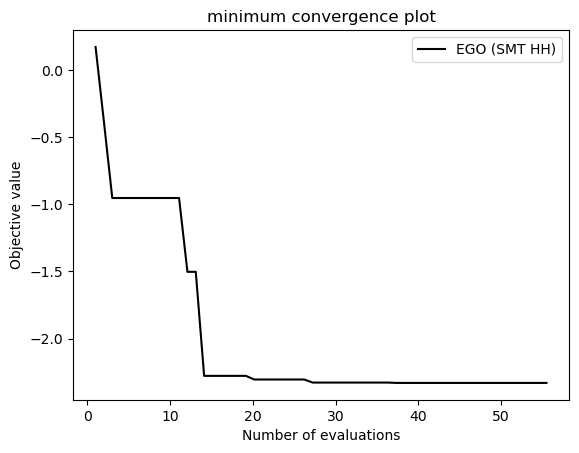

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
#to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k", label='EGO (SMT HH)')
plt.legend()
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()

 ## Bayesian optimization of mixed Branin test function: a mixed integer problem

The 2D function to optimize is described by: 
- 1 discrete variable $\in [-5, 10]$
- 1 continuous variable $\in [0., 15.]$

In [62]:
#Branin function with a integer variable and a continuous variable
fun = Branin(ndim=2)
xtypes = [XType.ORD, XType.FLOAT]
xlimits = fun.xlimits
xspecs = XSpecs(xtypes=xtypes, xlimits=xlimits)

#Initial doe
n_doe = 10
sampling = MixedIntegerSamplingMethod(FullFactorial, xspecs)
xdoe = sampling(n_doe)

#Bayesian optimization 
n_iter = 20

sm = KRG(xspecs=xspecs, print_global=False, categorical_kernel= MixIntKernelType.CONT_RELAX,)
criterion = "EI"  # 'EI' or 'SBO' or 'LCB'

ego = EGO(
    xdoe=xdoe,
    n_iter=n_iter,
    criterion=criterion,
    surrogate=sm,
    enable_tunneling=False,
    random_state=42,
        )

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=fun)
print('Optimal point found',x_opt,y_opt)    


Optimal point found [-3.         11.94679689] [0.49407055]


[-3.         11.94679689] [0.49407055]


Text(0.5, 1.0, 'Mixed Branin - optimization process')

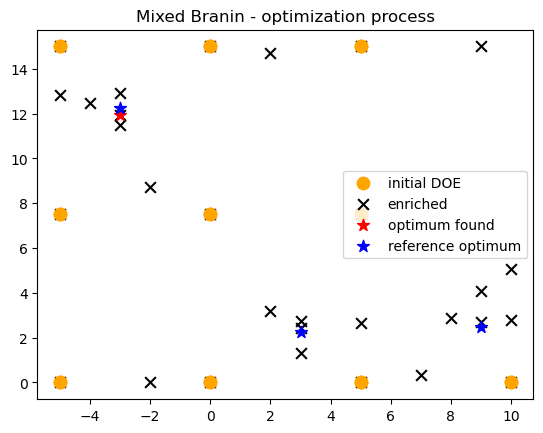

In [63]:
# 3 optimal points possible in the continuous Branin function: [-pi, 12.275], [pi, 2.275], [9.42478, 2.475] 
#for the modified integer Branin function
xref=np.array([[-3, 12.275], [3, 2.275], [9, 2.475]])
print(x_opt,y_opt)


fig = plt.figure()
plt.scatter(xdoe.T[0],xdoe.T[1],s=80,marker="o",color="orange",label='initial DOE')
plt.scatter(x_data.T[0],x_data.T[1],s=60,marker="x",color="black",label='enriched')
plt.scatter(xdoe.T[0],xdoe.T[1],s=80,marker="o",color="orange")
plt.scatter(x_opt[0],x_opt[1],s=80,marker="*",color="red",label='optimum found')
plt.scatter(xref[:,0],xref[:,1],s=80,marker="*",color="blue",label='reference optimum')
plt.legend()

plt.title("Mixed Branin - optimization process")

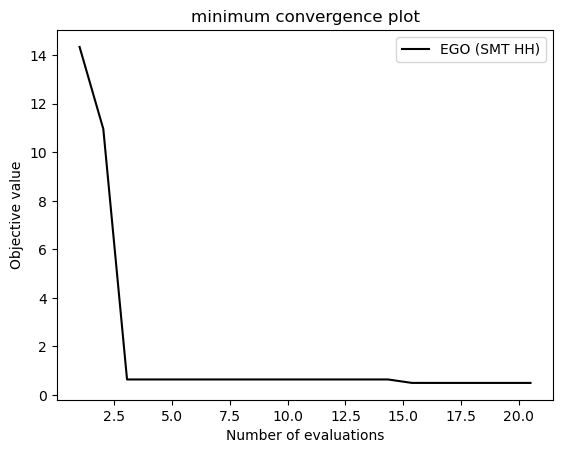

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
#to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k", label='EGO (SMT HH)')
plt.legend()
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()

## Bayesian optimization of hierarchical Goldstein test function: a mixed hierarchical problem

First, we recall the optimization problem:
\begin{equation}
\begin{split}
& \min  f( x^{cat}_{neutral}, x^{quant}_{neutral}, x^{cat}_{m}, x^{quant}_{decreed}  ) \\
& \mbox{w.r.t.} \ \  x^{cat}_{m} = w_1 \in \{ 0,1,2,3 \} \\
& \quad \quad \quad x^{quant}_{decreed} = (x_3,x_4,z_1,z_2) \in \{ 0,100 \}^2 \times \{ 0,1,2 \}^2   \\
& \quad \quad \quad x^{cat}_{neutral} =w_2 \in \{ 0,1 \} \\
& \quad \quad \quad x^{quant}_{neutral} = (x_1,x_2,x_5,z_3,z_4) \in \{ 0,100 \}^3 \times \{ 0,1,2 \}^2   \\
\end{split}
\end{equation}

The hierarchical and mixed function $f$ is defined as a hierarchical function that depends on $f_0$, $f_1$, $f_2$ and $Gold_\text{cont}$ as follows
\begin{equation}
\begin{split}
   &f({x_1}, {x_2}, {x_3}, {x_4}, {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_1}, {w_2})  = \\
    &  \quad \  \mathbb{1}_{w_1=0} f_0( {x_1}, {x_2},  {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2}) \\
    & + \mathbb{1}_{w_1=1} f_1 ({x_1}, {x_2}, {x_3}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  \\
    & + \mathbb{1}_{w_1=2} f_2 ({x_1}, {x_2}, {x_4}, {z_1}, {z_3}, {z_4}, {x_5}, {w_2})  \\
   & + \mathbb{1}_{w_1=3}  Gold_{\text{cont}} ({x_1}, {x_2}, {x_3}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2}).
\end{split}
\end{equation}

Then, the functions $f_0$, $f_1$ and $f_2$ are defined as mixed variants of $Gold_\text{cont}$ as such

\begin{equation}
\begin{split}
   f_0( {x_1}, {x_2},  {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  = &\\
       & \mathbb{1}_{z_2=0} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,20, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,20, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,20, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
       & \mathbb{1}_{z_2=1} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,50, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,50, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,50, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
      & \mathbb{1}_{z_2=2} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,80, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,80, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,80, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
  \end{split}
  \end{equation}
  
  
  \begin{equation*}
  \begin{split}
   f_1 ({x_1}, {x_2}, {x_3}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  &= \\
       &  \mathbb{1}_{z_2=0}  Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},20, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_2=1} Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},50, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_2=2}Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},80, {z_3}, {z_4}, {x_5},  {w_2})  \\
  \end{split}
\end{equation*}    
      
 \begin{equation*}
  \begin{split}     
   f_2 ({x_1}, {x_2}, {x_4}, {z_1}, {z_3}, {z_4}, {x_5}, {w_2})  = &\\
       &  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, 50, {x_2}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})  
\end{split}
\end{equation*}

To finish with, the function $Gold_{\text{cont}}$ is given by
\begin{equation}
\begin{split}
    & Gold_{\text{cont}} ({x_1}, {x_2}, {x_3}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2}) = 
        53.3108
        + 0.184901   {x_1}  \\
        &- 5.02914   {x_1} ^3   .10    ^{-6}
        + 7.72522    {x_1} ^{z_3}    .10    ^{-8}
        - 0.0870775    {x_2}
        - 0.106959    {x_3}  \\
        &+ 7.98772    {x_3} ^{z_4}    .10    ^{-6} 
         + 0.00242482    {x_4}
        + 1.32851    {x_4} ^3    .10    ^{-6}
        - 0.00146393    {x_1}    {x_2}\\
        &- 0.00301588    {x_1}    {x_3} 
         - 0.00272291    {x_1}    {x_4}
        + 0.0017004    {x_2}    {x_3}
        + 0.0038428    {x_2}    {x_4}\\
       & - 0.000198969    {x_3}    {x_4} 
        + 1.86025    {x_1}    {x_2}    {x_3}    .10    ^{-5}
        - 1.88719    {x_1}    {x_2}    {x_4}    .10    ^{-6}\\
       & + 2.50923    {x_1}    {x_3}    {x_4}    .10    ^{-5} 
        - 5.62199    {x_2}    {x_3}    {x_4}    .10    ^{-5} 
        +  {w_2} \left( 5    \cos \left( \frac{ 2 \pi}{100}  x_5 \right) - 2\right).
\end{split}
\end{equation}



Here is an illustration of the problem with the associated variables
![alternative text](https://github.com/SMTorg/smt/blob/master/tutorial/schema_var_goldstein.png?raw=true)

In [65]:
#Goldstein function
def H(x1, x2, x3, x4, z3, z4, x5, cos_term):
    h = (
        53.3108
        + 0.184901 * x1
        - 5.02914 * x1**3 * 10 ** (-6)
        + 7.72522 * x1**z3 * 10 ** (-8)
        - 0.0870775 * x2
        - 0.106959 * x3
        + 7.98772 * x3**z4 * 10 ** (-6)
        + 0.00242482 * x4
        + 1.32851 * x4**3 * 10 ** (-6)
        - 0.00146393 * x1 * x2
        - 0.00301588 * x1 * x3
        - 0.00272291 * x1 * x4
        + 0.0017004 * x2 * x3
        + 0.0038428 * x2 * x4
        - 0.000198969 * x3 * x4
        + 1.86025 * x1 * x2 * x3 * 10 ** (-5)
        - 1.88719 * x1 * x2 * x4 * 10 ** (-6)
        + 2.50923 * x1 * x3 * x4 * 10 ** (-5)
        - 5.62199 * x2 * x3 * x4 * 10 ** (-5)
    )
    if cos_term:
        h += 5.0 * np.cos(2.0 * np.pi * (x5 / 100.0)) - 2.0
    return h


def f0(x1, x2, z1, z2, z3, z4, x5, cos_term):
    c1 = z1 == 0
    c2 = z1 == 1
    c3 = z1 == 2

    c4 = z2 == 0
    c5 = z2 == 1
    c6 = z2 == 2

    y = (
        c4
        * (
            c1 * H(x1, x2, 20, 20, z3, z4, x5, cos_term)
            + c2 * H(x1, x2, 50, 20, z3, z4, x5, cos_term)
            + c3 * H(x1, x2, 80, 20, z3, z4, x5, cos_term)
        )
        + c5
        * (
            c1 * H(x1, x2, 20, 50, z3, z4, x5, cos_term)
            + c2 * H(x1, x2, 50, 50, z3, z4, x5, cos_term)
            + c3 * H(x1, x2, 80, 50, z3, z4, x5, cos_term)
        )
        + c6
        * (
            c1 * H(x1, x2, 20, 80, z3, z4, x5, cos_term)
            + c2 * H(x1, x2, 50, 80, z3, z4, x5, cos_term)
            + c3 * H(x1, x2, 80, 80, z3, z4, x5, cos_term)
        )
    )
    return y


def f1(x1, x2, x3, z2, z3, z4, x5, cos_term):
    c4 = z2 == 0
    c5 = z2 == 1
    c6 = z2 == 2

    y = (
        c4 * H(x1, x2, x3, 20, z3, z4, x5, cos_term)
        + c5 * H(x1, x2, x3, 50, z3, z4, x5, cos_term)
        + c6 * H(x1, x2, x3, 80, z3, z4, x5, cos_term)
    )
    return y


def f2(x1, x2, x4, z1, z3, z4, x5, cos_term):
    c1 = z1 == 0
    c2 = z1 == 1
    c3 = z1 == 2

    y = (
        c1 * H(x1, x2, 20, x4, z3, z4, x5, cos_term)
        + c2 * H(x1, x2, 50, x4, z3, z4, x5, cos_term)
        + c3 * H(x1, x2, 80, x4, z3, z4, x5, cos_term)
    )
    return y


def f_hv(X):
    y = []
    for x in X:
        if x[0] == 0:
            y.append(f0(x[2], x[3], x[7], x[8], x[9], x[10], x[6], cos_term=x[1]))
        elif x[0] == 1:
            y.append(f1(x[2], x[3], x[4], x[8], x[9], x[10], x[6], cos_term=x[1]))
        elif x[0] == 2:
            y.append(f2(x[2], x[3], x[5], x[7], x[9], x[10], x[6], cos_term=x[1]))
        elif x[0] == 3:
            y.append(H(x[2], x[3], x[4], x[5], x[9], x[10], x[6], cos_term=x[1]))
    return np.array(y)


#to define the variables: bounds, roles and types 
xlimits = [
    ["6,7", "3,7", "4,6", "3,4"],  # XRoles.META1 XType.ORD
    [0, 1],  # 0
    [0, 100],  # 1
    [0, 100],  # 2
    [0, 100],  # 3
    [0, 100],  # 4
    [0, 100],  # 5
    [0, 2],  # 6
    [0, 2],  # 7
    [0, 2],  # 8
    [0, 2],  # 9
]
xroles = [
    XRole.META,
    XRole.NEUTRAL,
    XRole.NEUTRAL,
    XRole.NEUTRAL,
    XRole.DECREED,
    XRole.DECREED,
    XRole.NEUTRAL,
    XRole.DECREED,
    XRole.DECREED,
    XRole.NEUTRAL,
    XRole.NEUTRAL,
]

xtypes = [
    (XType.ENUM, 4),
    XType.ORD,
    XType.FLOAT,
    XType.FLOAT,
    XType.FLOAT,
    XType.FLOAT,
    XType.FLOAT,
    XType.ORD,
    XType.ORD,
    XType.ORD,
    XType.ORD,
]
xspecs = XSpecs(xtypes=xtypes, xlimits=xlimits, xroles=xroles)

#Build the initial DOE
rseed = 42 #seed for the sampling
n_doe = 12 #size of the initial DOE
sampling = MixedIntegerSamplingMethod(LHS, xspecs, criterion="ese", random_state=rseed)
Xt = sampling(n_doe)

#Bayesian optimization
n_iter = 70 #less to reduce time
criterion = "EI"
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=Xt,
    surrogate=KRG(
        xspecs=xspecs,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE, # other options: .CONT_RELAX .GOWER, .EXP_HOMO_HSPHERE, .HOMO_HSPHERE
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL, # other options: .ALG_KERNEL, .ARC_KERNEL
        theta0=[1e-2],
        n_start=5,
        corr="squar_exp",
        print_global=False,
    ),
    verbose=True,
    enable_tunneling=False,
    random_state=rseed,
    n_start=10,
)

x_opt, y_opt, dnk, x_data, y_data = ego.optimize(fun=f_hv)
print("Optimal points",x_opt, y_opt)

Initial DOE given
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 5.0
Internal optimization succeeded at EGO iter = 6.0
Internal optimization succeeded at EGO iter = 7.0
Internal optimization succeeded at EGO iter = 8.0
Internal optimization succeeded at EGO iter = 9.0
Internal optimization succeeded at EGO iter = 10.0
Internal optimization succeeded at EGO iter = 11.0
Internal optimization succeeded at EGO iter = 12.0
Internal optimization succeeded at EGO iter = 13.0
Internal optimization succeeded at EGO iter = 14.0
Internal optimization succeeded at EGO iter = 15.0
Internal optimization succeeded at EGO iter = 16.0
Internal optimization succeeded at EGO iter = 17.0
Internal optimization succeeded at EGO iter = 18.0
Internal optimization s

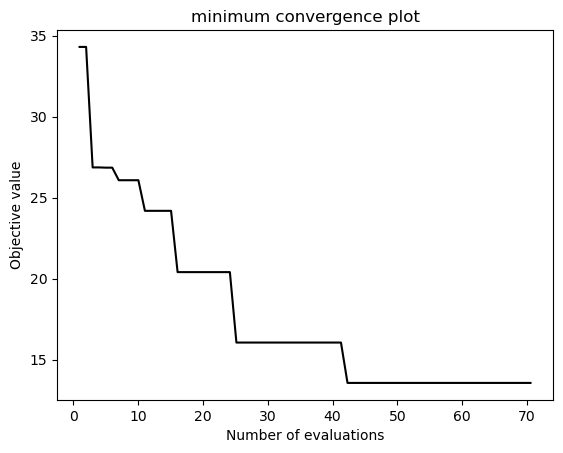

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
#to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k",label="EGO (SMT Arc Kernel)")
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()